## 千兆病理图像癌细胞转移检测
## Detecting Cancer Metastases on Gigapixel Pathology Images

In [1]:
import openslide
import numpy as np
from pylab import *

# 读取包含有肿瘤区域的大图（全切片病理图像）
origin_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/origin_images/Tumor_005.tif"
origin_slide = openslide.open_slide(origin_images_path)

# 读取该肿瘤区域的标注图
annotation_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/annotation_images/Tumor_005_Mask.tif"
mask_slide = openslide.open_slide(annotation_images_path)

### 首先找到感兴趣区域

In [2]:
from pylab import *
import numpy as np

# 感兴趣区域锁定函数
def locate_ROI(origin_slide,level=6):

    origin_widths,origin_heights = origin_slide.dimensions

    object_widths,object_heights = origin_slide.level_dimensions[level]

    rgb_list_y = list()
    rgb_list_x = list()
    rgb_var_x = []
    rgb_var_y = []
    rgb_var_xi = []
    rgb_var_yi = []

    # 寻找有效区域的y值、高度
    for k in range(100):
        slide = origin_slide.read_region((0, k*origin_heights//100), level, (object_widths, object_heights//50)) 
        slide_arr = array(slide.convert("RGB"))
        arrR = np.mean(slide_arr[:,:,:1])
        arrG = np.mean(slide_arr[:,:,1:2])
        arrB = np.mean(slide_arr[:,:,2:3])
        rgb_list_y.append((arrR,arrG,arrB))
    for i,rgbVar in enumerate(rgb_list_y):
        rgb_var_y.append(np.var(rgbVar))
        if np.var(rgbVar)>=1:
            rgb_var_yi.append(i)

#     print(rgb_var_yi)
    effective_y = min(rgb_var_yi)*origin_heights//100        #有效区域的左上顶点y坐标找到了
    effective_heights = (max(rgb_var_yi)-min(rgb_var_yi))*origin_heights//100 + origin_heights//50  #有效区域的高度也出来了
#     print("有效区域的ｙ值是：%d" %effective_y, "有效区域的高度是：%d" %effective_heights)

    # 寻找有效区域的x值、宽度
    for j in range(100):
        slide = origin_slide.read_region((j*origin_widths//100, effective_y), level, 
                                          (object_widths//50, effective_heights//62))     # 循环顺序读取50宽的区域
    #     slide = origin_slide.read_region((j*origin_widths//100, 0), level, 
    #                                       (object_widths//50, object_heights))     # 循环顺序读取50宽的区域

        slide_arr = array(slide.convert("RGB"))
        arrR = np.mean(slide_arr[:,:,:1])
        arrG = np.mean(slide_arr[:,:,1:2])
        arrB = np.mean(slide_arr[:,:,2:3])
        rgb_list_x.append((arrR,arrG,arrB))
    for i,rgbVar in enumerate(rgb_list_x):
        rgb_var_x.append(np.var(rgbVar))
        if np.var(rgbVar)>=2:
            rgb_var_xi.append(i)

#     print(rgb_var_xi)
    effective_x = min(rgb_var_xi)*origin_widths//100        # 有效区域的左上顶点y坐标找到了
    effective_widths = (max(rgb_var_xi) - min(rgb_var_xi))*origin_widths//100 + origin_widths//50  # 有效区域的宽度也出来了

    return effective_x,effective_y,effective_widths,effective_heights

In [3]:
effective_x,effective_y,effective_widths,effective_heights = locate_ROI(origin_slide)

In [4]:
effective_x,effective_y,effective_widths,effective_heights

(18580, 125199, 41071, 50518)

这个有效区域，经过手动调试，起点坐标：(17600,124700) ，区域长宽：(44800,57600)



### mask 的有效区域，定位比较容易

In [5]:
from pylab import *
import numpy as np

def locate_ROI_mask(mask_slide,mask_level=7):

    # level0　的尺寸
    mask_widths, mask_heights = mask_slide.dimensions
    # level7 的尺寸
    mask_level_widths, mask_level_heights = mask_slide.level_dimensions[mask_level]

    mask_level_slide = mask_slide.read_region((0, 0), mask_level, (mask_level_widths, mask_level_heights))
    mask_level_slide_gray = mask_level_slide.convert("L")
    mask_level_slide_arr = array(mask_level_slide_gray)

    mask_y, mask_x = nonzero(mask_level_slide_arr)  # 因为mask是黑白图，只需直接获得非零像素的坐标
    # mask_x, mask_y
    tumor_leftup_x = (min(mask_x)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_leftup_y = (min(mask_y)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_x = (max(mask_x)+1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_y = (max(mask_y)+1) * int(mask_slide.level_downsamples[mask_level])
    
#     print(tumor_leftup_x,tumor_leftup_y,tumor_rightdown_x,tumor_rightdown_y)
    mask_effective_widths = tumor_rightdown_x - tumor_leftup_x
    mask_effective_heights = tumor_rightdown_y - tumor_leftup_y

    return tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights

In [6]:
tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights = locate_ROI_mask(mask_slide)

In [7]:
tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights

(57600, 136320, 2048, 3712)

## 训练数据生成函数

由于数据来源于全切片组织病理图，经过处理后，得到了有效区域，但仍然不能直接拿来训练，需要写一个数据生成器data_generator，从slide中随机取训练所需尺寸大小(299,299)的patch，并处理成带标签的数据格式((1,299,299,3),(1,2))。

使用自编写的 generator 函数时，需要添加多进程保护，否则 models.fit_generator() 在调用 generator 并设置 workers=2 时会报错。


    class threadsafe_iter:
        def __init__(self, it):
            self.it = it
            self.lock = threading.Lock()

        def __iter__(self):
            return self

        def __next__(self):
            with self.lock:
                return self.it.__next__()

    def threadsafe_generator(f):
        def g(*args, **kw):
            return threadsafe_iter(f(*args, **kw))
        return g


    @threadsafe_generator
    def data_generator(widths=299,heights=299):
        pass


并且，在 python3 中使用 next 时，要 __next__ 这样用。

In [8]:
import numpy as np
from PIL.Image import Image
from pylab import *
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import threading

class threadsafe_iter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()

def threadsafe_generator(f):
    def g(*args, **kw):
        return threadsafe_iter(f(*args, **kw))
    return g

@threadsafe_generator
# for i in range(30):    # 这个其实就是 batch_size
#     widths, heights = 299, 299
def data_generator(widths=299,heights=299):
    while True:
        random_num = np.random.random(1)
#         print("0到１之间的随机数是：%s"%random_num)

        if random_num > 0.5:
            # 定义随机坐标,一定要取到一张含有tumor的图片
            random_x = np.random.randint(tumor_leftup_x, tumor_leftup_x + mask_effective_widths - widths)  
            random_y = np.random.randint(tumor_leftup_y, tumor_leftup_y + mask_effective_heights - heights)
    #             print("取tumor随机点坐标是：%d,%d"%(random_x,random_y))
            random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
            random_img_mask_arr = array(random_img_mask.convert("L"))
            random__img_y, random_img_x = nonzero(random_img_mask_arr)
            while len(random_img_x)==0:
                random_x = np.random.randint(tumor_leftup_x, tumor_leftup_x + mask_effective_widths - widths)
                random_y = np.random.randint(tumor_leftup_y, tumor_leftup_y + mask_effective_heights - heights)
    #                 print("取tumor随机点坐标是：%d,%d"%(random_x,random_y))
                random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                random_img_mask_arr = array(random_img_mask.convert("L"))
                random__img_y, random_img_x = nonzero(random_img_mask_arr)

            #*********************上面这个 while 循环结束后，就产生了一个合格的坐标点*********************#
            random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

            #***接下来就给他贴标签，并处理成训练所需的数据结构***#
            random_img_arr = array(random_img.convert("RGB"))
            x = np.expand_dims(random_img_arr, axis=0)/255.
            y = to_categorical(0,2)    
        else:
            # 定义随机坐标，一定要取到一张不含有tumor的normal图片
            random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)   # 大图上,nomal有效区的起点和终点
            random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
    #             print("取normal随机点坐标是：%d,%d"%(random_x,random_y))
            random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
            random_img_mask_arr = array(random_img_mask.convert("L"))
            random__img_y, random_img_x = nonzero(random_img_mask_arr)
            random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

#             print("随机情况",len(random_img_x),(array(random_img.convert("RGB"))).std())

            while (array(random_img.convert("RGB"))).std()<20.0:
                random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
                random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
    #                 print("取normal随机点坐标是：%d,%d" %(random_x,random_y))
                random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                random_img_mask_arr = array(random_img_mask.convert("L"))
                random__img_y, random_img_x = nonzero(random_img_mask_arr)
                random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

#             print("颜色检测情况",len(random_img_x),(array(random_img.convert("RGB"))).std())

            while len(random_img_x) != 0:
                random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
                random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
    #                 print("取normal随机点坐标是：%d,%d" %(random_x,random_y))
                random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                random_img_mask_arr = array(random_img_mask.convert("L"))
                random__img_y, random_img_x = nonzero(random_img_mask_arr)
                random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

#             print("非tumor区检测情况",len(random_img_x), (array(random_img.convert("RGB"))).std())

            #*********************上面这个 while 循环结束后，就产生了一个合格的坐标点*********************#
            random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

            #***接下来就给他贴标签，并处理成训练所需的数据结构***#
            random_img_arr = array(random_img.convert("RGB"))
            x = np.expand_dims(random_img_arr, axis=0)/255.
            y = to_categorical(1,2) 
        yield (x,y)

Using TensorFlow backend.


In [9]:
# a = data_generator()
# a.__next__() 　　　　# yield要用next调用

In [10]:
# %time example_X, example_y  = next(data_generator())    # yield要用next调用

In [11]:
# example_X.shape,example_y.shape

### 注意这里的第一个数表示batch_size


接下来可以开始训练了。

In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import SGD


def Creat_InvepV3(num_lay_out=1024,classes=2,dropout=0.5):
    img_width, img_height = 299, 299
    base_model = InceptionV3(weights="imagenet", include_top=False,
                             input_shape=(img_width, img_height, 3))
    x = base_model.output
    # x = Flatten()(x)
    # x = Dense(num_lay_out)(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = Dropout(dropout)(x)
    # x = Dense(classes)(x)
    # x = BatchNormalization()(x)
    # x = Activation('softmax')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_lay_out, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=SGD(lr=0.05, momentum=0.9, decay=0.5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
from __future__ import division
import keras
from keras.callbacks import CSVLogger
import gc
import time

def train_model():
    keras.backend.tensorflow_backend.clear_session()
    epochs = 20
    model = Creat_InvepV3()
    csvlogger = CSVLogger('training0817_10.log', append=True)
    model.fit_generator(data_generator(),
                        steps_per_epoch=100,
                        epochs=epochs,
                        validation_data=data_generator(),
                        validation_steps=20,
                        verbose=1,
                        workers=10,
                        max_q_size=1,
                        callbacks=[csvlogger])
    model.save('model0817_20.h5')
    gc.collect()

start_time = time.clock()
train_model()
end_time = time.clock()
print("模型训练消耗时间： %.1f 分钟"%((end_time - start_time) / 60.0,))

Epoch 1/20
100/100 [==============================] - 16s - loss: 7.4211 - acc: 0.5400 - val_loss: 10.4768 - val_acc: 0.3500
Epoch 2/20
100/100 [==============================] - 12s - loss: 7.7367 - acc: 0.5200 - val_loss: 6.4472 - val_acc: 0.6000
Epoch 3/20
100/100 [==============================] - 12s - loss: 7.8979 - acc: 0.5100 - val_loss: 9.6709 - val_acc: 0.4000oss: 
Epoch 4/20
100/100 [==============================] - 11s - loss: 8.3814 - acc: 0.4800 - val_loss: 8.0590 - val_acc: 0.5000.474
Epoch 5/20
100/100 [==============================] - 11s - loss: 8.2202 - acc: 0.4900 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/20
100/100 [==============================] - 11s - loss: 8.3814 - acc: 0.4800 - val_loss: 6.4472 - val_acc: 0.6000.484
Epoch 7/20
100/100 [==============================] - 11s - loss: 6.9308 - acc: 0.5700 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 8/20
100/100 [==============================] - 11s - loss: 8.7038 - acc: 0.4600 - val_loss: 8.8650 - val_acc: 0

分析曲线

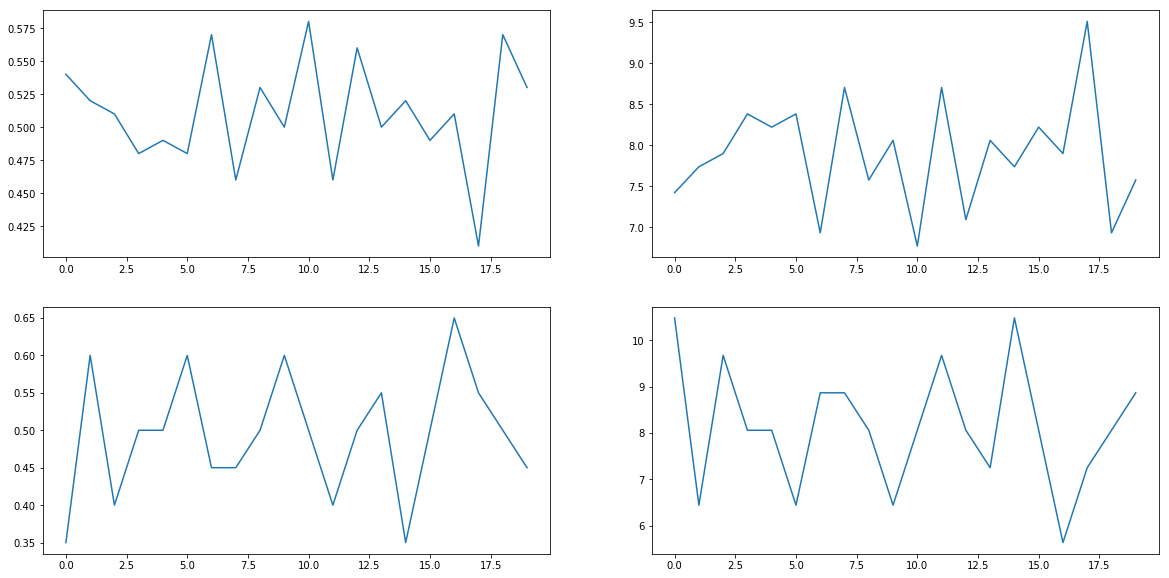

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

train_log = open("training0817_10.log")
log_line = train_log.readlines()
# log_line
epoch = []
acc = []
loss = []
val_acc = []
val_loss = []

for i in range(len(log_line)):
    if i<20:
        line_list = list(eval(log_line[i+1]))
        epoch.append(line_list[0])
        acc.append(line_list[1])
        loss.append(line_list[2])
        val_acc.append(line_list[3])
        val_loss.append(line_list[4])

fig, axes = plt.subplots(2,2,figsize=(20,10))
ax = axes.ravel()
ax[0].plot(epoch,acc)
ax[1].plot(epoch,loss)
ax[2].plot(epoch,val_acc)
ax[3].plot(epoch,val_loss)
